In [1]:
import torch
from torchvision import datasets
import torch.nn as nn
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

In [5]:
train_data = datasets.MNIST('.', True,ToTensor(),download=True)
test_data = datasets.MNIST('.', False,ToTensor(),download=True)

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9.91M/9.91M [00:00<00:00, 10.9MB/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28.9k/28.9k [00:00<00:00, 349kB/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1.65M/1.65M [00:00<00:00, 3.03MB/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4.54k/4.54k [00:00<00:00, 10.4MB/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [ ]:
len(train_data), len(test_data)

(60000, 10000)

In [6]:
train_dataloader = DataLoader(train_data,batch_size=100,shuffle=True)
test_dataloader = DataLoader(test_data,batch_size=100,shuffle=True)
len(train_dataloader)

600

In [ ]:
img, label = next(iter(train_dataloader))


In [ ]:
img[0]

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

In [ ]:
label[0]

tensor(7)

In [12]:
#initializing some parameters
hidden_size = 128
num_layers = 2
output_size = 10
input_size = 28
sequence_length = 28
epochs = 10

In [13]:
class LSTM(nn.Module):
    def __init__(self, hidden_size, input_size, output_size, num_layers):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.out_layer = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Create initial hidden and cell states
        hidden_states = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        cell_states = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Process through LSTM
        out, (hidden_n, cell_n) = self.lstm(x, (hidden_states, cell_states))

        # Take the output of the last time step
        out = self.out_layer(out[:, -1, :])
        return out


model = LSTM(
    hidden_size=hidden_size,  # number of features in hidden state
    input_size=input_size,    # number of expected features in input x
    output_size=output_size,  # number of expected features in output
    num_layers=num_layers     # number of recurrent layers
).to(device)
model

LSTM(
  (lstm): LSTM(28, 128, num_layers=2, batch_first=True)
  (out_layer): Linear(in_features=128, out_features=10, bias=True)
)

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [16]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),0.001)

In [17]:
losses = []  # Initialize as list to store loss history
for epoch in range(epochs):
    epoch_loss = 0
    model.train()

    # Loop through batches
    for batch, (data, labels) in enumerate(train_dataloader):
        # Move data to correct device
        data = data.reshape(-1,sequence_length,input_size)
        data = data.to(device)
        labels = labels.to(device)

        # Forward pass
        output = model(data)
        loss = loss_fn(output, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accumulate batch loss
        epoch_loss += loss.item()

    # Calculate average loss for epoch
    avg_epoch_loss = epoch_loss / len(train_dataloader)
    losses.append(avg_epoch_loss)  # Store loss history

    print(f"epoch: {epoch+1} | loss: {avg_epoch_loss:.4f}")

epoch: 1 | loss: 0.0450
epoch: 2 | loss: 0.0232
epoch: 3 | loss: 0.0143
epoch: 4 | loss: 0.0092
epoch: 5 | loss: 0.0062
epoch: 6 | loss: 0.0044
epoch: 7 | loss: 0.0028
epoch: 8 | loss: 0.0018
epoch: 9 | loss: 0.0012
epoch: 10 | loss: 0.0013


In [18]:
def calculate_accuracy(model, dataloader, device):
    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0

    # Don't compute gradients during evaluation
    with torch.no_grad():
        for data, labels in dataloader:
            # Prepare data
            data = data.squeeze(1)  # Remove channel dimension for MNIST
            data = data.to(device)
            labels = labels.to(device)

            # Get predictions
            outputs = model(data)

            # Get predicted class (highest probability)
            _, predicted = torch.max(outputs.data, 1)

            # Update counts
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Calculate accuracy
    accuracy = 100 * correct / total
    return accuracy

In [19]:
calculate_accuracy(model=model,dataloader=test_dataloader,device=device)

98.87

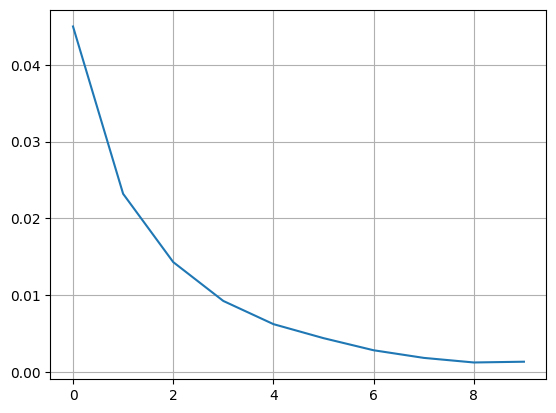

In [24]:
import matplotlib.pyplot as plt

# Plot loss

plt.plot(losses)
plt.grid()
plt.show()

